In [15]:
import pandas as pd
import pylab
from astropy.timeseries import LombScargle
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
from astroML.plotting import setup_text_plots
from scipy.stats import norm
setup_text_plots(fontsize=8, usetex=False)


In [16]:
#extracting data from dat file

path = 'data.xlsx'
df = pd.read_csv(path)
data = df.iloc[:,8].tolist()

avg_data = np.mean(data)

rel_diff = data - avg_data

year = df.iloc[:,2].tolist()

dy = 0.1


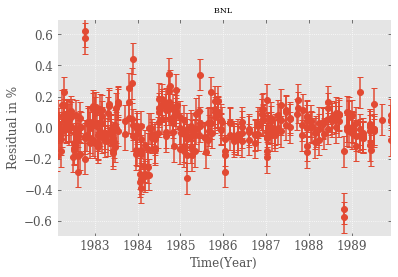

In [17]:
#plotting the above data 
import statistics

# print(np.diff(year))
# print(statistics.median(np.diff(year))
# )

plt.errorbar(year,rel_diff*100,dy,fmt='o')		
plt.ylim(-0.7,0.7) 

plt.title('BNL ')
plt.xlabel('Time(Year)',fontsize=12)
plt.ylabel('Residual in %',fontsize=12)
plt.tick_params(labelsize=12)
plt.savefig('BNL1.png', bbox_inches='tight')

plt.show()

In [18]:
#Applying LombScargle Periodogram

ls = LombScargle(year, rel_diff, dy)
frequency, power = ls.autopower()


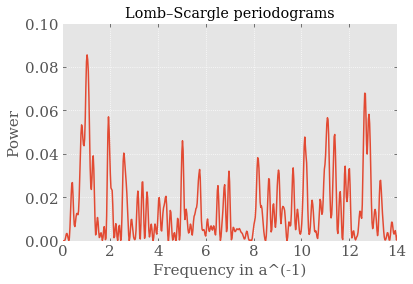

In [19]:
#plotting power vs frequency | xlim(8,14)

plt.xlim(0,14)
plt.ylim(0,0.1)
plt.plot(frequency, power) 

plt.style.use('ggplot')
plt.title('Lomb–Scargle periodograms')
plt.xlabel('Frequency in a^(-1)',fontsize=15)
plt.ylabel('Power',fontsize=15)
plt.tick_params(labelsize=15)
plt.savefig('BNL2.png', bbox_inches='tight')

plt.show()

In [43]:
x = np.array(frequency[:600])
y1 = np.array(power[:600])
# print(power[:600])
# plt.xlim(0,14)
y2 = [0]*600
y2[40] = 3.3834976323720314
y2[75] = 1.4437778275248119
y2[433] = 1.403654819582531 
y2[494] = 2.3278977969359
y2[501] =1.553799438290175
y2[511] =0.9345275280761307
sig=ls.false_alarm_probability(y1, method='baluev')
zscore=norm.isf(sig)
zscore[zscore<0]=0




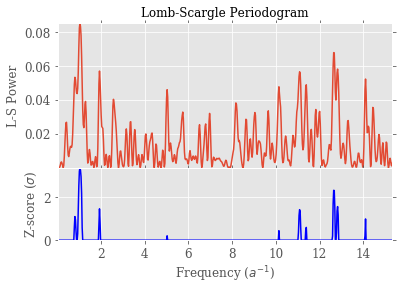

In [59]:
from matplotlib import gridspec

# Simple data to display in various forms
#plt.tick_params(labelsize=12)
fig = plt.figure()
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
# the fisrt subplot
ax0 = plt.subplot(gs[0])
ax0.set_title('Lomb-Scargle Periodogram',fontsize=12)
ax0.tick_params(labelsize=12)
# log scale for axis Y of the first subplot
# ax0.set_yscale("log")
line0, = ax0.plot(x, y1)

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
#ax1.tick_params(labelsize=12)
ax1.tick_params(labelsize=12)
line1, = ax1.plot(x, zscore, linestyle='-',color='b')
plt.setp(ax0.get_xticklabels(), visible=False)
#plt.tick_params(labelsize=12)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

ax0.set_xlabel('Frequency ($a^{-1}$)',fontsize=12)
ax0.set_ylabel('L-S Power' ,fontsize=12)
ax1.set_ylabel('Z-score ($\sigma$)',fontsize=12)
# put lened on first subplot
# ax0.legend((line0, line1), ('L-S Power', 'Z-score($\sigma$)'), loc='lower left')
plt.xlabel('Frequency ($a^{-1}$)',fontsize=12)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.savefig('BNLnew1')

plt.show()

In [58]:
from scipy import interpolate

freq = np.array(frequency)
powr = np.array(power)

xnew = np.linspace(freq.min(),freq.max(),300)
powr_smooth = interpolate.splrep(freq,powr) #Use splrep instead of spline

#Select desired width values
freq_vals = [9.43,11,12.7]   

#splev returns the value of your spline evaluated at the width values.    
powr = interpolate.splev(freq_vals, powr_smooth)
print(powr)
print(ls.false_alarm_probability(0.00279077, method='bootstrap') )
print(ls.false_alarm_probability(0.0374749, method='bootstrap') )
print(ls.false_alarm_probability(0.0560283, method='bootstrap') )

[0.00279077 0.0374749  0.0560283 ]
1.0
0.85
0.06599999999999995


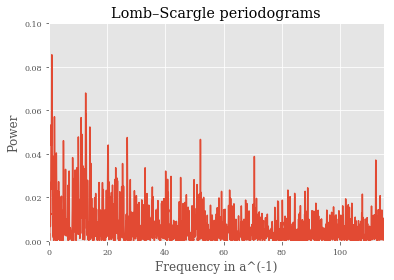

In [31]:
#plotting power vs frequency | xlim(0,115)

plt.xlim(0,115)
plt.ylim(0,0.1)
plt.plot(frequency, power) 
plt.style.use('ggplot')
plt.title('Lomb–Scargle periodograms')
plt.xlabel('Frequency in a^(-1)')
plt.ylabel('Power')
plt.show()

In [32]:
#Defining FAP to find significance of peaks 

def false_alarm(method):
	return ls.false_alarm_probability(z, method=method, maximum_frequency=5)


#peak detection

from scipy.signal import argrelextrema

# for local maxima
a = argrelextrema(power, np.greater)

# for local minima
b = argrelextrema(power, np.less)


In [33]:
import xlsxwriter 
  
workbook = xlsxwriter.Workbook('BNL_FAP.xlsx') 
  
worksheet = workbook.add_worksheet() 
  

worksheet.write('A1', 'Power') 
worksheet.write('B1', 'Frequency') 
worksheet.write('C1', 'FAP : baluev') 
worksheet.write('D1', 'FAP : davies') 
worksheet.write('E1', 'FAP : naive') 
worksheet.write('F1', 'FAP : bootstrap') 


row = 1
col = 0
count = 0
sig = []
for i in range(len(a[0])): 
    worksheet.write(row, col, power[a[0][i]]) 
    worksheet.write(row, col + 1, frequency[a[0][i]]) 

    worksheet.write(row, col + 2, ls.false_alarm_probability(power[a[0][i]], method='baluev'))
    worksheet.write(row, col + 3, ls.false_alarm_probability(power[a[0][i]], method='davies'))
    worksheet.write(row, col + 4, ls.false_alarm_probability(power[a[0][i]], method='naive'))

    q = ls.false_alarm_probability(power[a[0][i]], method='bootstrap')
    worksheet.write(row, col + 5, q)
    if  q<0.1:
        count = count + 1
        print(count)
        worksheet.write(row, col + 6, q)
        sig.append(a[0][i])


    row += 1

workbook.close() 
print(sig)

1
2


KeyboardInterrupt: 